## Introduction to the Grammar of Graphics and Text Analysis Notebook

Welcome to our second notebook and second session of Visualizing Humanities Data 🥳!!

Our agenda today is the following:

- Review homework assignment and answer questions
- Intro to Grammar of Graphics
- Visualizing Corpora and Text Analysis Basics
- Discuss Challenges of Visualizing Data-Derived From Text (time-permitting)

***

#### Homework Review

Who wants to share their example? Questions or errors you discovered?

In [1]:
import pandas as pd
import altair as alt

In [2]:
seattle_df = pd.read_csv('Seattle-Library_2015-2021.csv', delimiter=",", encoding="utf-8")

In [3]:
seattle_df.head()

,Title,Creator,MaterialType,Checkouts,CheckoutYear,CheckoutMonth,Publisher,PublicationYear,Subjects,UsageClass,CheckoutType
0,Frog and toad all year / by Arnold Lobel.,"Lobel, Arnold",BOOK,34,2016,10,"Harper & Row,",c1976.,"Friendship Fiction, Frogs Juvenile fiction, To...",Physical,Horizon
1,"My brilliant friend : childhood, adolescence /...","Ferrante, Elena",BOOK,110,2016,10,"Europa Editions,",2012,"Friendship Fiction, Naples Italy Fiction",Physical,Horizon
2,Star trek [videorecording] / Paramount ; Spygl...,NaN,VIDEODISC,36,2016,10,"Paramount Home Entertainment,",c2009.,"Kirk James T 2233 2371 Drama, Spock Mr Drama, ...",Physical,Horizon
3,The Man in the High Castle,Philip K. Dick,EBOOK,63,2016,10,Houghton Mifflin Harcourt Trade and Reference,2012,"Fiction, Science Fiction",Digital,OverDrive
4,"The Fifth Season: Broken Earth Series, Book 1",N. K. Jemisin,EBOOK,44,2016,10,"Hachette Digital, Inc.",2015,"Fantasy, Fiction, Thriller",Digital,OverDrive


In [6]:
# Our original chart code from Monday
seattle_material_grouped = seattle_df.groupby(['MaterialType', 'CheckoutYear']).size().reset_index(name='counts')
selection = alt.selection_multi(fields=['CheckoutYear'], bind='legend')
alt.Chart(seattle_material_grouped).mark_bar().encode(
    x=alt.X('MaterialType', sort='-y'),
    y='counts',
    color='CheckoutYear:N',
    tooltip=['MaterialType', 'counts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
)

alt.Chart(...)

In [38]:
seattle_material_grouped = seattle_df.groupby(['MaterialType', 'Checkouts']).size().reset_index(name='counts')
pts = alt.selection(type="single", encodings=['x'])
rect = alt.Chart(seattle_material_grouped).mark_rect().encode(
    alt.X('MaterialType:O'),
    alt.Y('Checkouts:Q', bin=True),
    alt.Color('count()',
        scale=alt.Scale(scheme='greenblue'),
        legend=alt.Legend(title='Total Records')
    )
)
circ = rect.mark_point().encode(
    alt.ColorValue('grey'),
    alt.Size('count()',
        legend=alt.Legend(title='Records in Selection')
    )
).transform_filter(
    pts
)
bar = alt.Chart(seattle_material_grouped).mark_bar().encode(
    x='MaterialType:N',
    y='count()',
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=550,
    height=200
).add_selection(pts)
alt.vconcat(
    rect + circ,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

alt.VConcatChart(...)

***

**Zoe's Solution** 

First need to decide what I want to visualize 🤔?

Looking at `seattle_df` and our graph above, I was most interested in whether this trend of `Material Types` corresponded to `Checkouts`. Would having more print books lead to more checkouts or videodiscs, etc...? Essentially curious to what is the relationship between material acquisition and library patron behavior.

So how to visualize this relationship? Need to decide on a few key steps:

1. Decide what data I need to represent this relationship and transform `seattle_df` to represent that data
2. Decide on how best to represent this relationship visually

In [8]:
# So first need checkouts data. Altair has built-in groupby functionality but our number of rows is too great to use it so we'll create a new dataframe with grouped-by checkout data.
seattle_checkouts = seattle_df.groupby(['MaterialType','CheckoutYear'])['Checkouts'].sum().reset_index(name='total_checkouts')
seattle_checkouts

,MaterialType,CheckoutYear,total_checkouts
0,AUDIOBOOK,2015,44663
1,AUDIOBOOK,2016,74295
2,AUDIOBOOK,2017,114625
3,AUDIOBOOK,2018,204860
4,AUDIOBOOK,2019,387261
...,...,...,...
106,VIDEODISC,2021,23427
107,VIDEOREC,2017,45
108,VISUAL,2015,298
109,VISUAL,2016,350


In [9]:
# Now with this data we could make another bar chart but first the goal was to use something different than bar and second it won't be well suited to the relationship between frequency and availability

In [10]:
# Could we use seattle_material_grouped? How would we use the two dataframes together (hint https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)?


In [11]:
seattle_materials_checkouts = pd.merge(seattle_material_grouped, seattle_checkouts, on=['MaterialType', 'CheckoutYear'])

In [12]:
# So how do we visualize this relationship? Let's take a look at this chart!
alt.Chart(seattle_materials_checkouts).mark_circle(size=100).encode(
    x=alt.X('total_checkouts', axis=alt.Axis(title='Total Number of Checkouts by Year and MaterialType')),
    y=alt.Y('counts', axis=alt.Axis(title='Total Number of MaterialTypes by Year')),
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'total_checkouts']
).properties(
    title='Comparing Frequency of Checkouts to Availability of Seattle Library Materials',
    width=500,
    height=300
)

alt.Chart(...)

So first I decided to use `mark_circle` (could have also used point but circle made more sense given color encoding) and then added in code to first rename both the axes (read more on customizations like this here https://altair-viz.github.io/user_guide/customization.html), and code to specify the color scale I wanted to use (you can use any Vega color scheme or even pass in your own https://vega.github.io/vega/docs/schemes/).

Seems like there might be some interesting results with the `Book` type since it does not follow the same positive relationship as the other types. 

To investigate further, I could add a regression line but I think in this case it would be helpful to compare to our original graph, which we can do by adjoining the two graphs into the same plot.

In [13]:
selection = alt.selection_multi(fields=['CheckoutYear'], bind='legend')
chart = alt.Chart(seattle_material_grouped).mark_bar().encode(
    x=alt.X('MaterialType', sort='-y'),
    y='counts',
    color='CheckoutYear:N',
    tooltip=['MaterialType', 'counts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
)

chart1 = alt.Chart(seattle_materials_checkouts).mark_circle(size=100).encode(
    x=alt.X('total_checkouts', axis=alt.Axis(title='Total Number of Checkouts by Year and MaterialType')),
    y=alt.Y('counts', axis=alt.Axis(title='Total Number of MaterialTypes by Year')),
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'total_checkouts']
).properties(
    title='Comparing Frequency of Checkouts to Availability of Seattle Library Materials',
    width=500,
    height=300
)
alt.hconcat(chart, chart1)

alt.HConcatChart(...)

So here we used Altair's horizontal concatenation to place our charts next to each other (you can read more about how to concat here https://altair-viz.github.io/user_guide/compound_charts.html#hconcat-chart) but it's not quite working. Let's tweak our code!

In [14]:
alt.hconcat(chart, chart1).resolve_scale(color='independent')

alt.HConcatChart(...)

Pretty easy actually! The `resolve_scale` helps us tell Altair that the color encodings are these two graphs are independent (you can read more about resolving scales here https://altair-viz.github.io/user_guide/scale_resolve.html).

Now we could be done here but there's a few issues. First we have duplicate information with `MaterialType` in both graphs so ideally we would try and re-format our charts to have this field be the legend for both charts. Also while we're at it we could add selection to both graphs as well!

In [15]:
# For time's sake going to just post the code here but ideally we would work on this together
selection = alt.selection_multi(fields=['MaterialType'], bind='legend')
chart = alt.Chart(seattle_material_grouped).mark_bar().encode(
    x=alt.X('CheckoutYear:N'),
    y='counts',
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
)

chart1 = alt.Chart(seattle_materials_checkouts).mark_circle(size=100).encode(
    x=alt.X('total_checkouts', axis=alt.Axis(title='Total Number of Checkouts by Year and MaterialType')),
    y=alt.Y('counts', axis=alt.Axis(title='Total Number of MaterialTypes by Year')),
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'total_checkouts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
)
alt.hconcat(chart, chart1)

alt.HConcatChart(...)

In [16]:
selection = alt.selection_multi(fields=['MaterialType'], bind='legend')
chart = alt.Chart(seattle_material_grouped).mark_bar().encode(
    x=alt.X('CheckoutYear:N'),
    y=alt.Y('counts', axis=alt.Axis(title='Total Number of MaterialTypes by Year')),
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
).transform_filter(
    alt.FieldOneOfPredicate(field='MaterialType', oneOf=['AUDIOBOOK', 'BOOK', 'EBOOK'])
)

chart1 = alt.Chart(seattle_materials_checkouts).mark_circle(size=100).encode(
    x=alt.X('total_checkouts', axis=alt.Axis(title='Total Number of Checkouts by Year and MaterialType')),
    y=alt.Y('counts', axis=alt.Axis(title='Total Number of MaterialTypes by Year')),
    color=alt.Color('MaterialType:N', scale=alt.Scale(scheme='tableau20')),
    tooltip=['MaterialType', 'counts', 'total_checkouts', 'CheckoutYear'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
).transform_filter(
    alt.FieldOneOfPredicate(field='MaterialType', oneOf=['AUDIOBOOK', 'BOOK', 'EBOOK'])
)
alt.hconcat(chart, chart1).properties(title='Impact of Pandemic on Seattle Library Acquisitions and Patron Behavior')

alt.HConcatChart(...)

Our charts look pretty great now! But this was also a lot of material and tweaks made very quickly let's break it down a bit. 

Time for some slides (https://docs.google.com/presentation/d/199J--Rv-1Y_J-2lu4aESluQ-OHVfoxgbtHaQLpmTa3k/edit?usp=sharing) and then a quick break

***

### Group Work Time: Intro to Text Analysis and Working with Textual Data

We the exception of dates and facets we have know covered the majority of Altair's functionality 🥳! While those final two things are tricky, the remainder of our session is going to be devoted to getting you comfortable testing out Altair and reading it's documentation, along with some discussion of the basics of text analysis.

Because we are such a large group and with some many levels of comfort with Python, today we're going to split into two groups (though you're welcome to bounce between them as well!).

Both groups are going to focus for the remainder of our session on one of the most simple but powerful tools for text analysis - word counts! I know it sounds basic and it is, but it is also one the best ways to try out different ways of applying the Grammar of Graphics to composing charts.

So both the homework exercise and the rest of today (unless we all magically fly through this) is going to be a dedicated to a chance to get your hands dirty.

For the two groups:

Group A is going to be doing a light introduction to text analysis foundations and then some code along examples with me of how we can use Altair to visualize word counts.

Group B is going to be doing the same thing but at their own pace. So they'll be using either the datasets I've provided or ones they've found (feel free to bring in your own data too!) and then trying to load in the data, and start doing some word counts. 

The homework exercise is to load in at least one dataset and then create at least one "good" and one "bad" data visualization based on data from word counts. Remember good and bad are subjective here, but ideally you should be trying to communicate some argument with your visualization, so explain to us why one graph does it better than the other.

BREAKOUT ROOM TIME (again feel free to float between rooms, but ideally you should be coding which ever room you are in!)

***

### Intro to Text Analysis and Working with Textual Data

For the remainder of our session we are going to be working with a dataset I use with my students when teaching web-scraping and the history of DH.

You can look at the code for web scraping in the `Pandas Web Scraping Humanist` notebook and find links to the exact webpages there as well.

I realize Humanist has problems as listserv, but I like using it in Intro to DH courses because it's both not totally impossible to web scrape and full of messy text.

In [418]:
humanist_vols = pd.read_csv('web_scraped_humanist_listserv.csv')

In [419]:
### Let's inspect our dataframe

##### Text Analysis with Python


In Python, there exists a few libraries specifically designed to work with text data.

- NLTK [https://www.nltk.org/](https://www.nltk.org/)

- SPACY [https://spacy.io/](https://spacy.io/)

- SCIKIT-LEARN [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)

Each of these libraries has its own history, and some of what they provide overlaps. Here's a helpful chart outlining some of their pros and cons.

![comparison](https://activewizards.com/content/blog/Comparison_of_Python_NLP_libraries/nlp-librares-python-prs-and-cons01.png)

Ultimately, which library you choose to use depends on what you want to do with your data, but there's some general principles for text analysis that you should consider regardless of method.

##### Word Counts and Zipf's Law

The library NLTK has a helpful built in Class called `FreqDist` that takes a list of words and outputs their frequency in a corpus [http://www.nltk.org/api/nltk.html?highlight=freqdist](http://www.nltk.org/api/nltk.html?highlight=freqdist)

Let's try it out with a subset of our data.

```python
from nltk import word_tokenize
from nltk import FreqDist

tokens = FreqDist(sum(humanist_vols[0:2]['text'].map(word_tokenize), []))
tokens.plot(30)
```

In [420]:
### Copy code here

We should get a graph that looks like this:
![counts](images/counts.png).

In this graph, if we had used all the words we would see this trend continue, like in the graph below.

![zipf](https://miro.medium.com/max/6072/1*GTpckiHyFLe04pUMeYDYOg.png)

This is “Zipf’s law:” the phenomenon means that the most common word is twice as common as the second most common word, three times as common as the third most common word, four times as common as the fourth most common word, and so forth.

It is named after the linguist George Zipf, who first found the phenomenon while laboriously counting occurrences of individual words in Joyce’s Ulysses in 1935.

This is a core textual phenomenon, and one you must constantly keep in mind: common words are very common indeed, and logarithmic scales are more often appropriate for plotting than linear ones. This pattern results from many dynamic systems where the “rich get richer,” which characterizes all sorts of systems in the humanities.

[https://tedunderwood.com/2013/02/20/wordcounts-are-amazing/](https://tedunderwood.com/2013/02/20/wordcounts-are-amazing/)


In [422]:
# Let's try doing some word counting with the humanist listerv dataset

<AxesSubplot:>

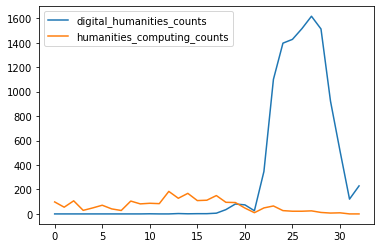

In [423]:
humanist_vols['humanities_computing_counts'] = humanist_vols.text.apply(lambda x: x.count('humanities computing'))
humanist_vols['digital_humanities_counts'] = humanist_vols.text.apply(lambda x: x.count('digital humanities'))
counts = humanist_vols[['digital_humanities_counts', 'humanities_computing_counts']]
counts.plot()

*What are some of the problems with this graph?*

Let's try rebuilding it in Altair, what we want to represent on our `x` and `y` axis?

Almost immediately you'll realize that we need to reshape our data to be able to show both counts.

In data analysis, you will often need to transform your dataset from `wide to long` and `long to wide` (that is adding more rows vs more columns). Pandas has a number of ways to do that, and you can read more about it here [https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-by-melt](https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-by-melt).

Today we're going to try melting our dataset to turn our `digital_humanities_counts` and `humanities_computing_counts` into rows.
![https://pandas.pydata.org/docs/_images/reshaping_melt.png](https://pandas.pydata.org/docs/_images/reshaping_melt.png)

So looking at the syntax, first we need to decide what our `id_vars` will be. Which raises the question of what else might we want to display in the graph? (*hint* think about time!)

In [424]:
# counts_melted = pd.melt(counts, id_vars=['dates'])

Now in `counts_melted` we should have columns for `dates`, `variable`, and `value`, which contains our transformed columns.

So let's try making our chart:

In [425]:
# alt.Chart(counts_melted).mark_line().encode(
#     x='dates',
#     y='value',
# )

This produces the following graph:

![first](images/first_pass.png)

*What do we need to add to our graph?* hint look below!

![color](images/color.png)

Let's try specifying the data types for Altair [https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types), which one would we use for each of our fields?

*What happens if we try using the temporal encoding on dates?*

One of the trickiest areas for data analysis is working with dates and times (think timezones and formatting!).

Pandas has built-in functionality to handle dates so we're going to try and add a column to our dataframe that holds the year. Take a look at the docs [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

*How could we get the year for each of our rows?*

In [427]:
# counts['year'] = counts.dates.str.split('-').str[0]
# counts['year'] = pd.to_datetime(counts.year, format='%Y', errors='ignore')

Now let's try rerunning our graph but using `year`.

![final](images/final.png)

Woot! We officially have recreated this graph and added more information that would be useful to a reader.

There's a few more things we could add like click events or tooltip hovers, but for now let's try and get you started on the homework exercise!
